In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cftime

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Reading Data 

In [2]:
# Nino 3 Index 
nino_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.nino/.NCEP_OIv2/.NINO3/dods'

def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

n3_ds = xr.open_dataset(nino_url, decode_times=False)
n3_ds = fix_calendar(n3_ds)
n3_ds = xr.decode_cf(n3_ds)

# cftime to datatime 
datetimeindex = n3_ds.indexes['T'].to_datetimeindex()
n3_ds['T'] = datetimeindex

# Anomaly 
n3 = n3_ds.NINO3
nmonths = len(n3)
n3a = n3.groupby('T.month') - n3.groupby('T.month').mean()

<ipython-input-2-62aa4ad1c8bc>:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = n3_ds.indexes['T'].to_datetimeindex()


In [3]:
# Precip 
precip_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc'
precip_ds = xr.open_dataset(precip_url)

# Select slice for Equatorial Eastern Pacific 
precip_ds = precip_ds.sel(lat = slice(30 , -30)).sel(lon = slice(210, 270))

In [337]:
# SST Anom
sst_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/.sst/dods'

sst_ds = xr.open_dataset(sst_url, decode_times=False)
sst_ds = fix_calendar(sst_ds)
sst_ds = xr.decode_cf(sst_ds)

# cftime to datatime 
datetimeindex = sst_ds.indexes['T'].to_datetimeindex()
sst_ds['T'] = datetimeindex

# Select Equatorial Eastern Pacific Values 
sst_ds = sst_ds.sel(Y = slice(-30 , 30)).sel(X = slice(210,270))

<ipython-input-337-8717299897b4>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = sst_ds.indexes['T'].to_datetimeindex()


# Precipitation 

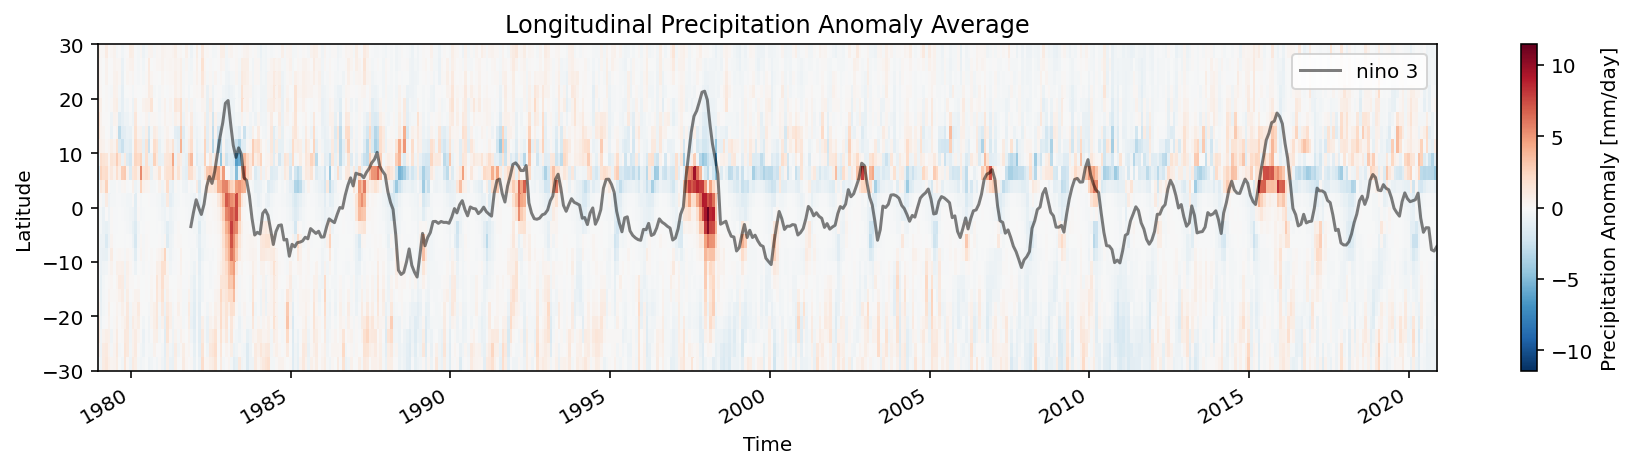

In [24]:
p = precip_ds.precip 
p_ave = p.mean('lon')
p_anom = p_ave.groupby('time.month') - p_ave.groupby('time.month').mean() 

im = p_anom.plot(x = 'time', figsize = (15,3), label = 'Precipitation [mm/day]', add_colorbar = False)
cb = plt.colorbar(im, orientation="vertical")
(6*n3a).plot(color = 'k', alpha = 0.5, label = 'nino 3')

cb.set_label(label='Precipitation Anomaly [mm/day]')

plt.legend(); 
plt.ylabel('Latitude');
plt.xlabel('Time');
plt.title('Longitudinal Precipitation Anomaly Average')
plt.savefig('precip_ts.jpeg')

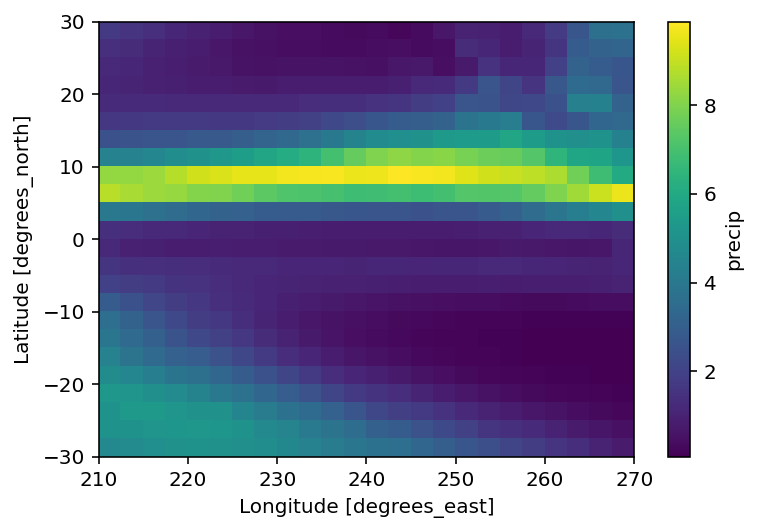

In [45]:
p.mean('time').plot()

## Correlation

Pearson Correlation: 

$$
    \rho_{X,Y} = \frac{\text{cov}(X,Y)}{\sigma_{X}\sigma_{Y}}
$$

In [25]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

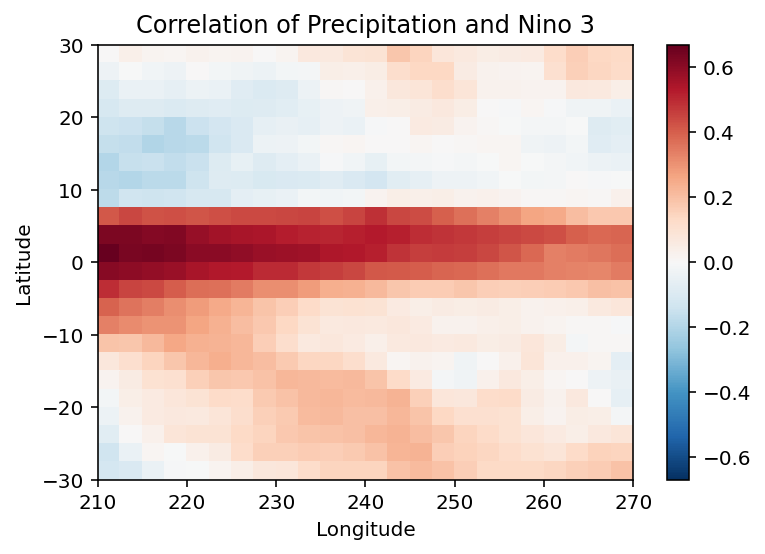

In [46]:
# Select value of p 
prcp_map = p.sel(time = slice('1981-11-01' , '2020-11-01'))

# Rename indecies 
prcp_map = prcp_map.rename({'time':'T', 'lat':'Y', 'lon':'X'})

# Reindex like 
prcp_map = prcp_map.T.reindex_like(n3, method='pad')

# Correlation
n3_prcp_corr = xr.corr(n3, prcp_map, dim = 'T') 

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

n3_prcp_corr.plot(x = 'X', y = 'Y')
# ax.coastlines()
plt.title('Correlation of Precipitation and Nino 3')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('Corr_Prcp_N3.jpeg')

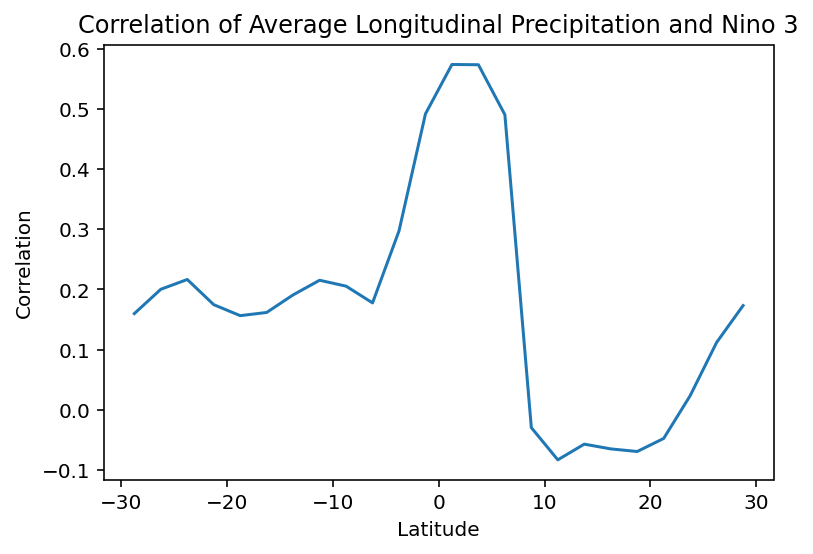

In [47]:
# Select value of p 
prcp = p_ave.sel(time = slice('1981-11-01' , '2020-11-01'))

# Rename indecies 
prcp = prcp.rename({'time':'T', 'lat':'Y'})

# Reindex like 
prcp = prcp.T.reindex_like(n3, method='pad')

# Correlation
n3_prcp_corr = xr.corr(n3, prcp, dim = 'T') 

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

n3_prcp_corr.plot(x = 'Y')
# ax.coastlines()
plt.title('Correlation of Average Longitudinal Precipitation and Nino 3')
plt.xlabel('Latitude')
plt.ylabel('Correlation')
plt.savefig('Corr_Prcp_N3.jpeg')

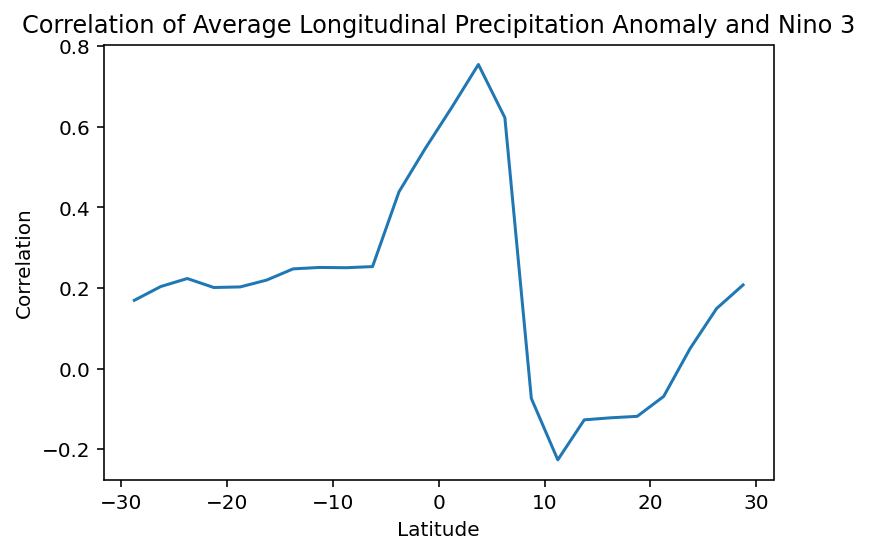

In [48]:
# Select value of p 
prcp_anom = p_anom.sel(time = slice('1981-11-01' , '2020-11-01'))

# Rename indecies 
prcp_anom = prcp_anom.rename({'time':'T', 'lat':'Y'})

# Reindex like 
prcp_anom_ri = prcp_anom.T.reindex_like(n3, method='pad')

# Correlation
n3_prcp_corr = xr.corr(n3, prcp_anom_ri, dim = 'T') 

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

n3_prcp_corr.plot(x = 'Y')
# ax.coastlines()
plt.title('Correlation of Average Longitudinal Precipitation Anomaly and Nino 3')
plt.xlabel('Latitude')
plt.ylabel('Correlation')
plt.savefig('Corr_PrcpAnom_N3.jpeg')

### By Monthly Values 

In [67]:
n3_nov = n3[0::12]
n3_dec = n3[1::12]
n3_jan = n3[2::12]
n3_feb = n3[3::12]
n3_mar = n3[4::12]
n3_apr = n3[5::12]
n3_may = n3[6::12]
n3_jun = n3[7::12]
n3_jul = n3[8::12]
n3_aug = n3[9::12]
n3_sep = n3[10::12]
n3_oct = n3[11::12]

In [130]:
prcp_t = prcp.transpose("T", "Y")
prcp_nov = prcp_t[0::12]
prcp_dec = prcp_t[1::12]
prcp_jan = prcp_t[2::12]
prcp_feb = prcp_t[3::12]
prcp_mar = prcp_t[4::12]
prcp_apr = prcp_t[5::12]
prcp_may = prcp_t[6::12]
prcp_jun = prcp_t[7::12]
prcp_jul = prcp_t[8::12]
prcp_aug = prcp_t[9::12]
prcp_sep = prcp_t[10::12]
prcp_oct = prcp_t[11::12]

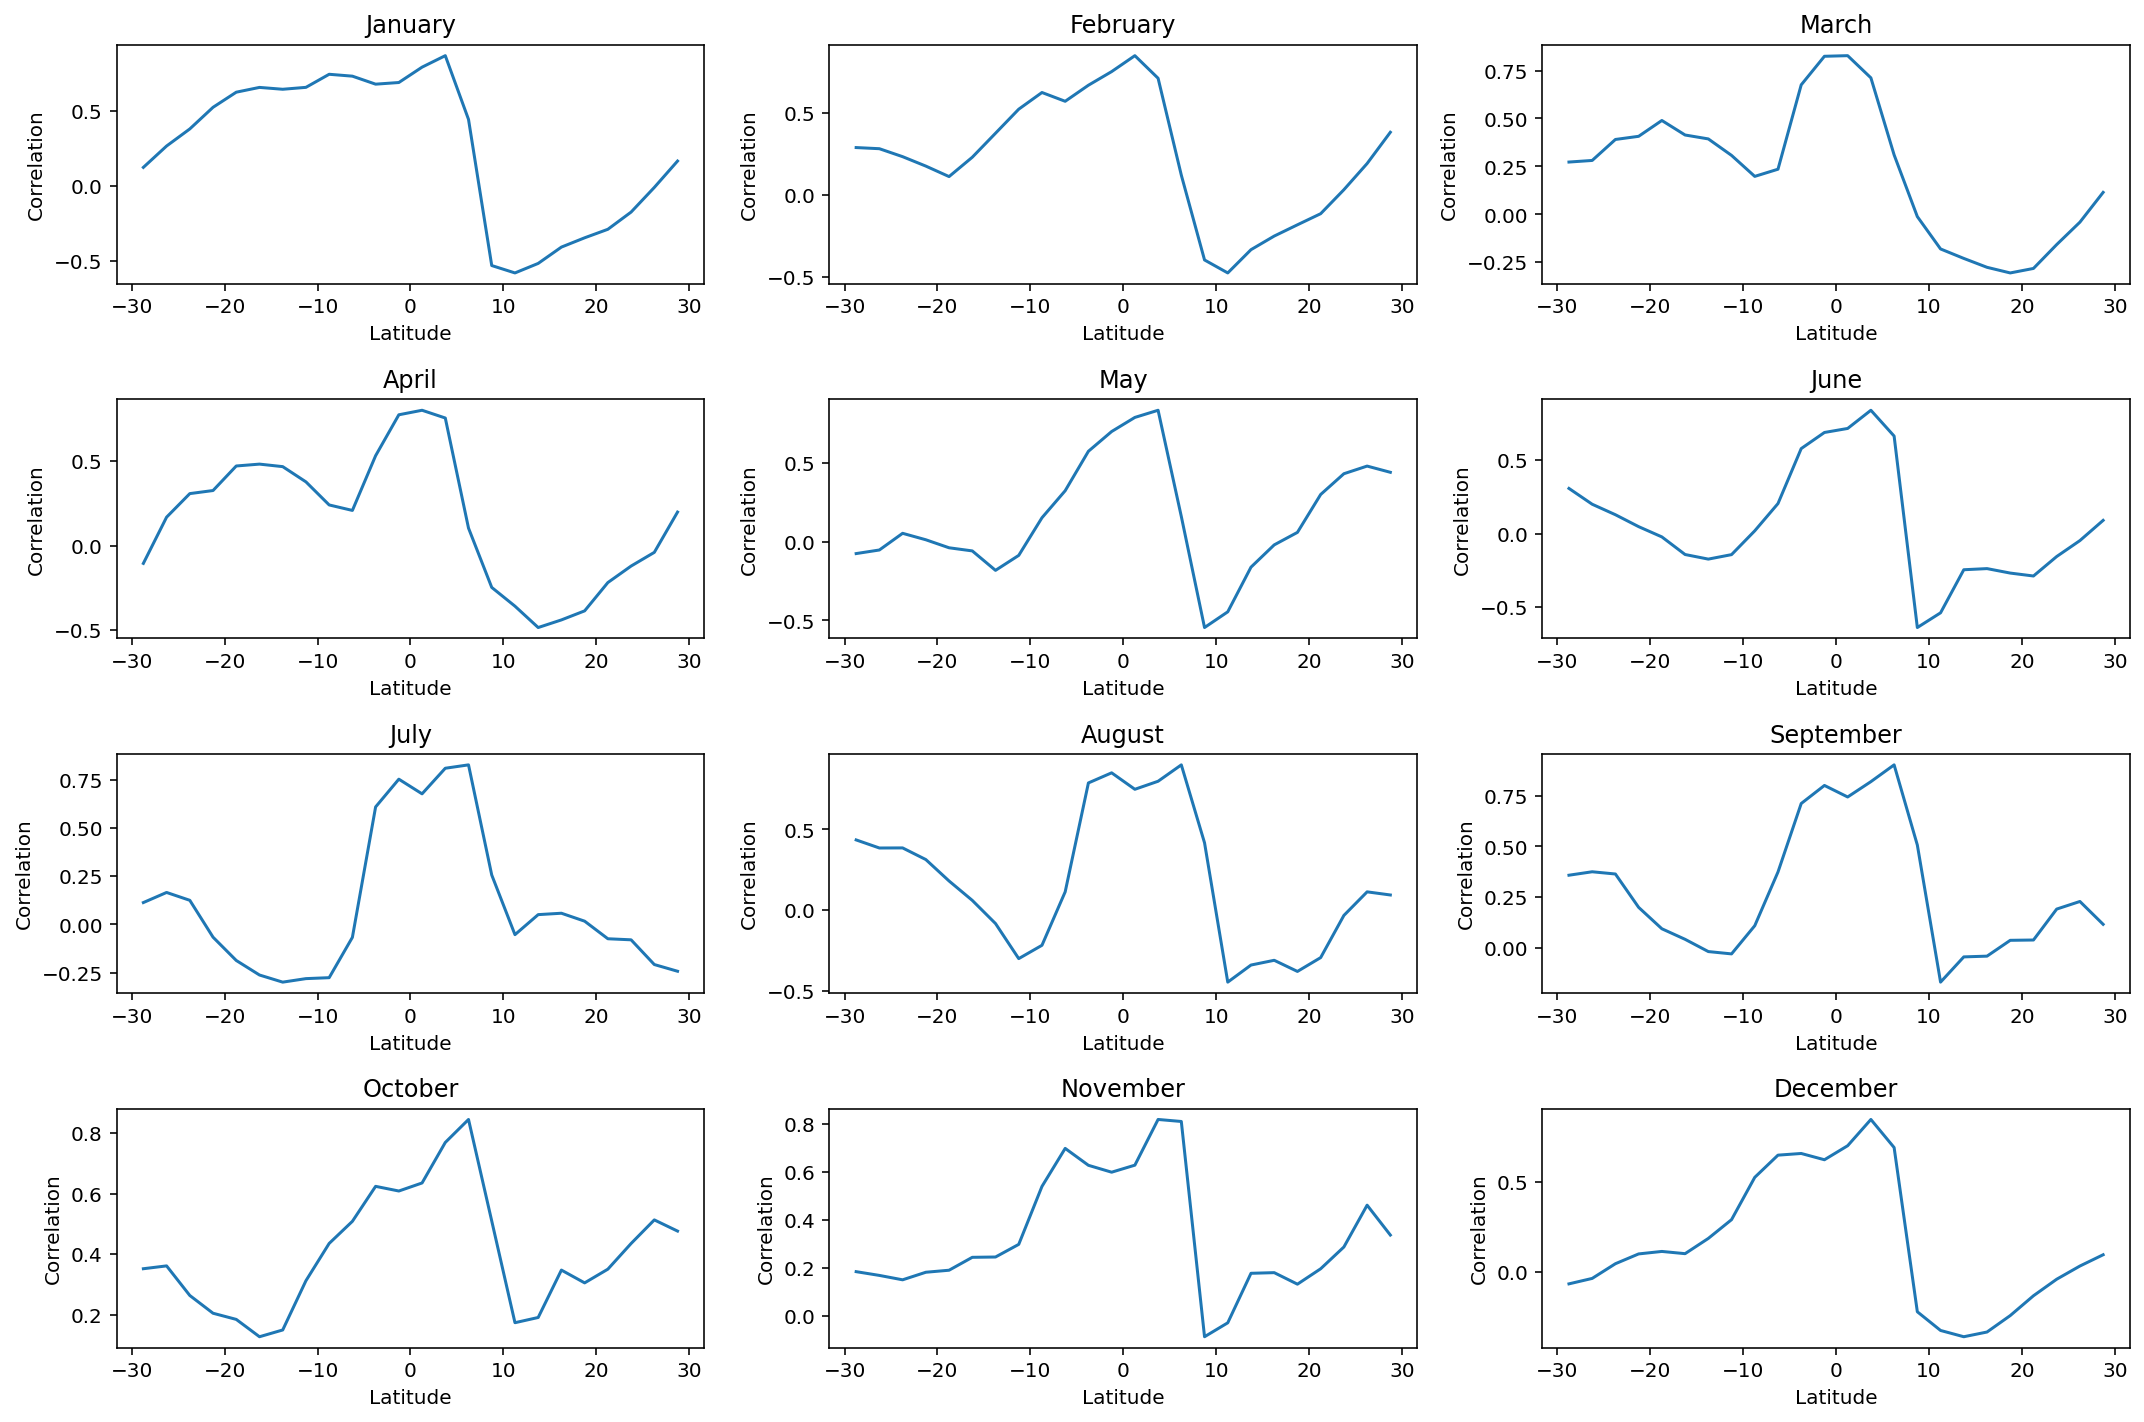

In [341]:
corr_jan = xr.corr(n3_jan, prcp_jan, dim = 'T')
corr_feb = xr.corr(n3_feb, prcp_feb, dim = 'T') 
corr_mar = xr.corr(n3_mar, prcp_mar, dim = 'T') 
corr_apr = xr.corr(n3_apr, prcp_apr, dim = 'T') 
corr_may = xr.corr(n3_may, prcp_may, dim = 'T') 
corr_jun = xr.corr(n3_jun, prcp_jun, dim = 'T') 
corr_jul = xr.corr(n3_jul, prcp_jul, dim = 'T') 
corr_aug = xr.corr(n3_aug, prcp_aug, dim = 'T') 
corr_sep = xr.corr(n3_sep, prcp_sep, dim = 'T') 
corr_oct = xr.corr(n3_oct, prcp_oct, dim = 'T') 
corr_nov = xr.corr(n3_nov, prcp_nov, dim = 'T') 
corr_dec = xr.corr(n3_dec, prcp_dec, dim = 'T') 

correlations = [corr_jan, corr_feb, corr_mar, corr_apr, corr_may, corr_jun, corr_jul, corr_aug, corr_sep, corr_oct, corr_nov, corr_dec]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(4, 3, figsize = (15,10))
ax = ax.flatten()

for i, corr in enumerate(correlations):

    corr.plot(x = 'Y', ax = ax[i])
    ax[i].set_title('%s'%months[i])
    ax[i].set_xlabel('Latitude')
    ax[i].set_ylabel('Correlation')

plt.tight_layout()
plt.savefig('Corr_Prcp_by_month.jpeg')


## Linear Regression

There seems to be sufficient correlation between the Nino 3 index and precipitation along the equator, so we can perform linear regression to predict average longitudinal precipitation. 

## Jan

(38, 24, 24)


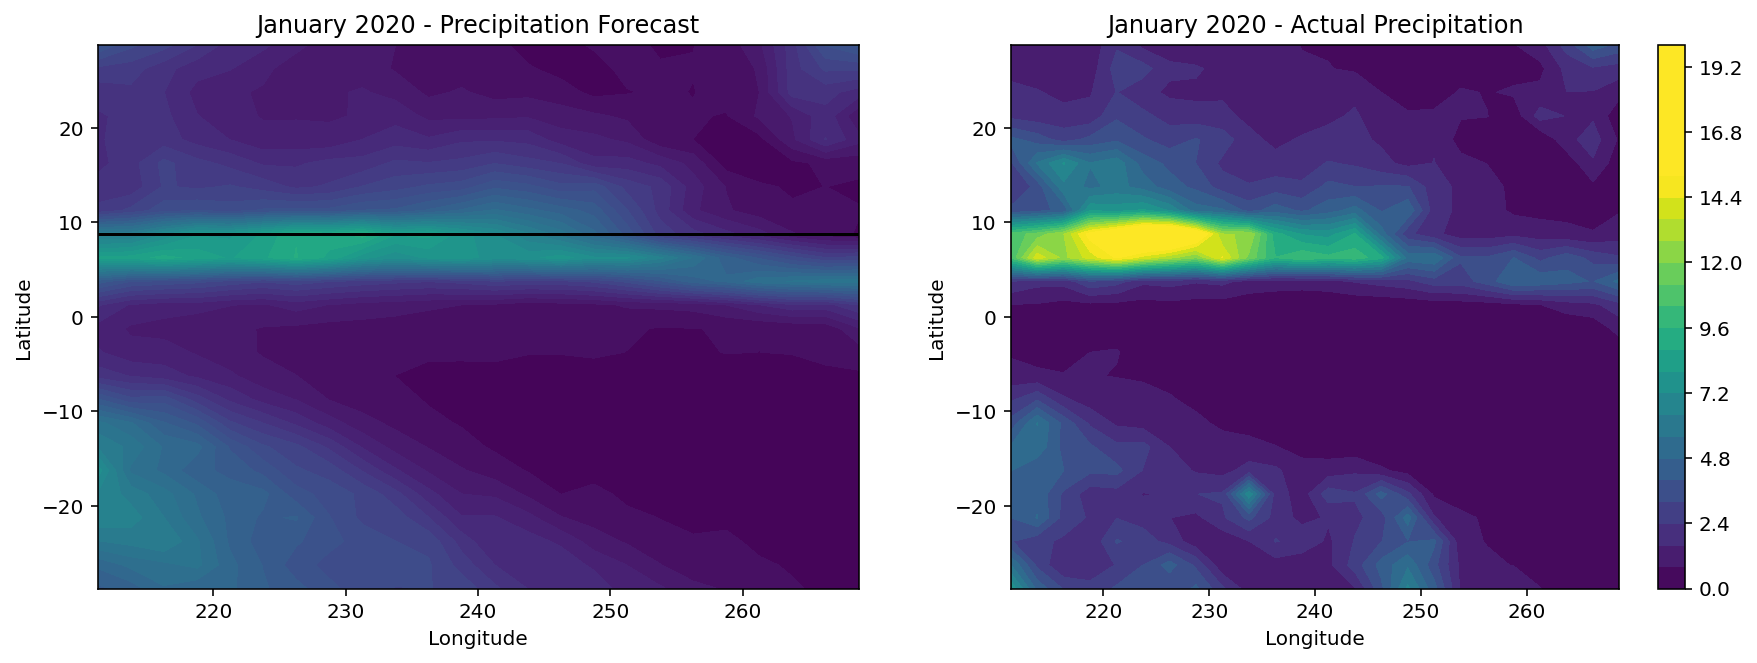

In [236]:
prcp_map_t = prcp_map.transpose("T", "X", "Y")
prcp_map_t_jan = prcp_map_t[2::12]

# Train our prediction on value from 2020
x = n3_jan[0:-1].values
xm = x.mean()
# xa = x - xm
x0 = n3_jan[-1].values
y = prcp_map_t_jan[:-1].values
N = len(y)

Nx = len(x)
X = np.empty((Nx,2))
X[:,1] = x
X[:,0] = 1

beta = np.empty((2, 24, 24))
yhat = np.empty((38, 24, 24))
y0_hat = np.empty((38, 24, 24))

for i in range(0, 24): 
    for j in range(0, 24): 
        beta[:,i,j] = inv(X.T@X)@X.T@y[:,i,j]
        yhat[:,i,j] = X@beta[:,i,j]
        y0_hat[:,i,j] = beta[1, i, j]*x0 + beta[0, i, j]

yhat = yhat.mean(axis=0)
y0_hat = y0_hat.mean(axis=0)

X = prcp_map_t_jan.X
Y = prcp_map_t_jan.Y
Xi,Yi = np.meshgrid(X,Y)

max_index = np.unravel_index(yhat.argmax(), yhat.shape)
max_row = max_index[0]

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

cs = ax[0].contourf(Xi, Yi, yhat.T, levels=30, vmin = 0, vmax = 15)

ax[0].set_title('January 2020 - Precipitation Forecast')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[0].hlines(Y[max_row], X.min(), X.max())

print(y.shape)
cs = ax[1].contourf(Xi, Yi, prcp_map_t_jan[-1].T.values, levels=30, vmin = 0, vmax = 15)

ax[1].set_title('January 2020 - Actual Precipitation')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

fig.colorbar(cs)

## February

(38, 24, 24)


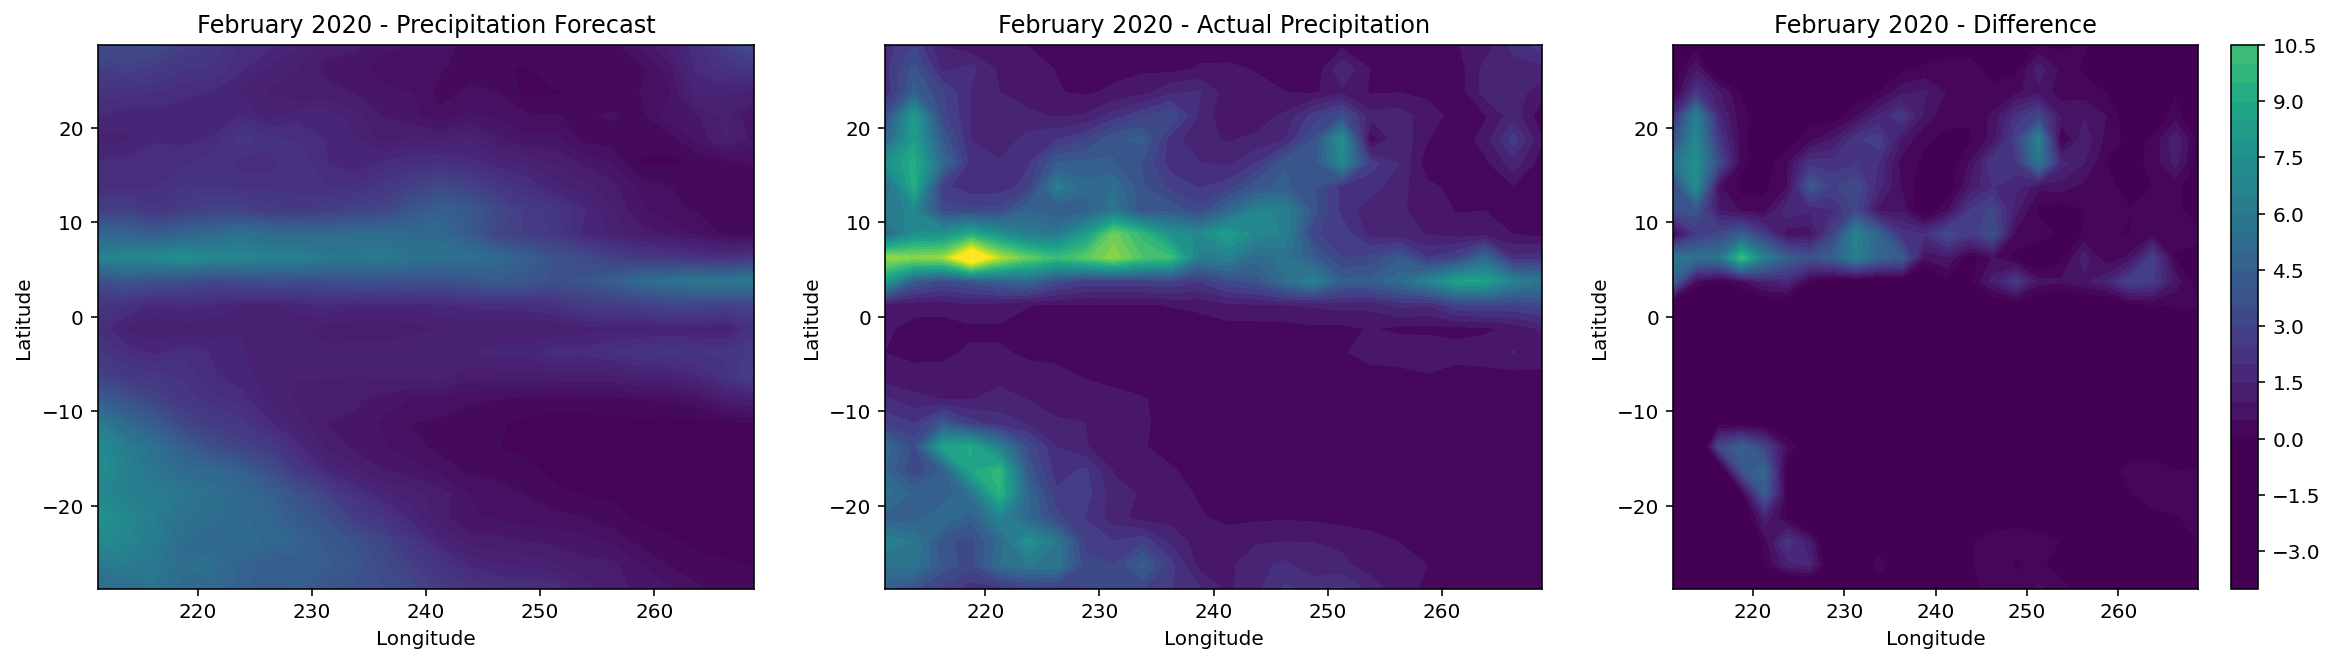

In [192]:
prcp_map_t = prcp_map.transpose("T", "X", "Y")
prcp_map_t_feb = prcp_map_t[3::12]

# Train our prediction on value from 2020
x = n3_feb[0:-1].values
xm = x.mean()
# xa = x - xm
x0 = n3_feb[-1].values
y = prcp_map_t_feb[:-1].values
N = len(y)

Nx = len(x)
X = np.empty((Nx,2))
X[:,1] = x
X[:,0] = 1

beta = np.empty((2, 24, 24))
yhat = np.empty((38, 24, 24))
y0_hat = np.empty((38, 24, 24))

for i in range(0, 24): 
    for j in range(0, 24): 
        beta[:,i,j] = inv(X.T@X)@X.T@y[:,i,j]
        yhat[:,i,j] = X@beta[:,i,j]
        y0_hat[:,i,j] = beta[1, i, j]*x0 + beta[0, i, j]

yhat = yhat.mean(axis=0)
y0_hat = y0_hat.mean(axis=0)

X = prcp_map_t_feb.X
Y = prcp_map_t_feb.Y
Xi,Yi = np.meshgrid(X,Y)

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

cs = ax[0].contourf(Xi, Yi, yhat.T, levels=30, vmin = 0, vmax = 15)

ax[0].set_title('February 2020 - Precipitation Forecast')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

print(y.shape)
cs = ax[1].contourf(Xi, Yi, prcp_map_t_feb[-1].T.values, levels=30, vmin = 0, vmax = 15)

ax[1].set_title('February 2020 - Actual Precipitation')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

cs = ax[2].contourf(Xi, Yi, prcp_map_t_feb[-1].T.values - yhat.T, levels=30, vmin = 0, vmax = 15)

ax[2].set_title('February 2020 - Difference')
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')

fig.colorbar(cs)

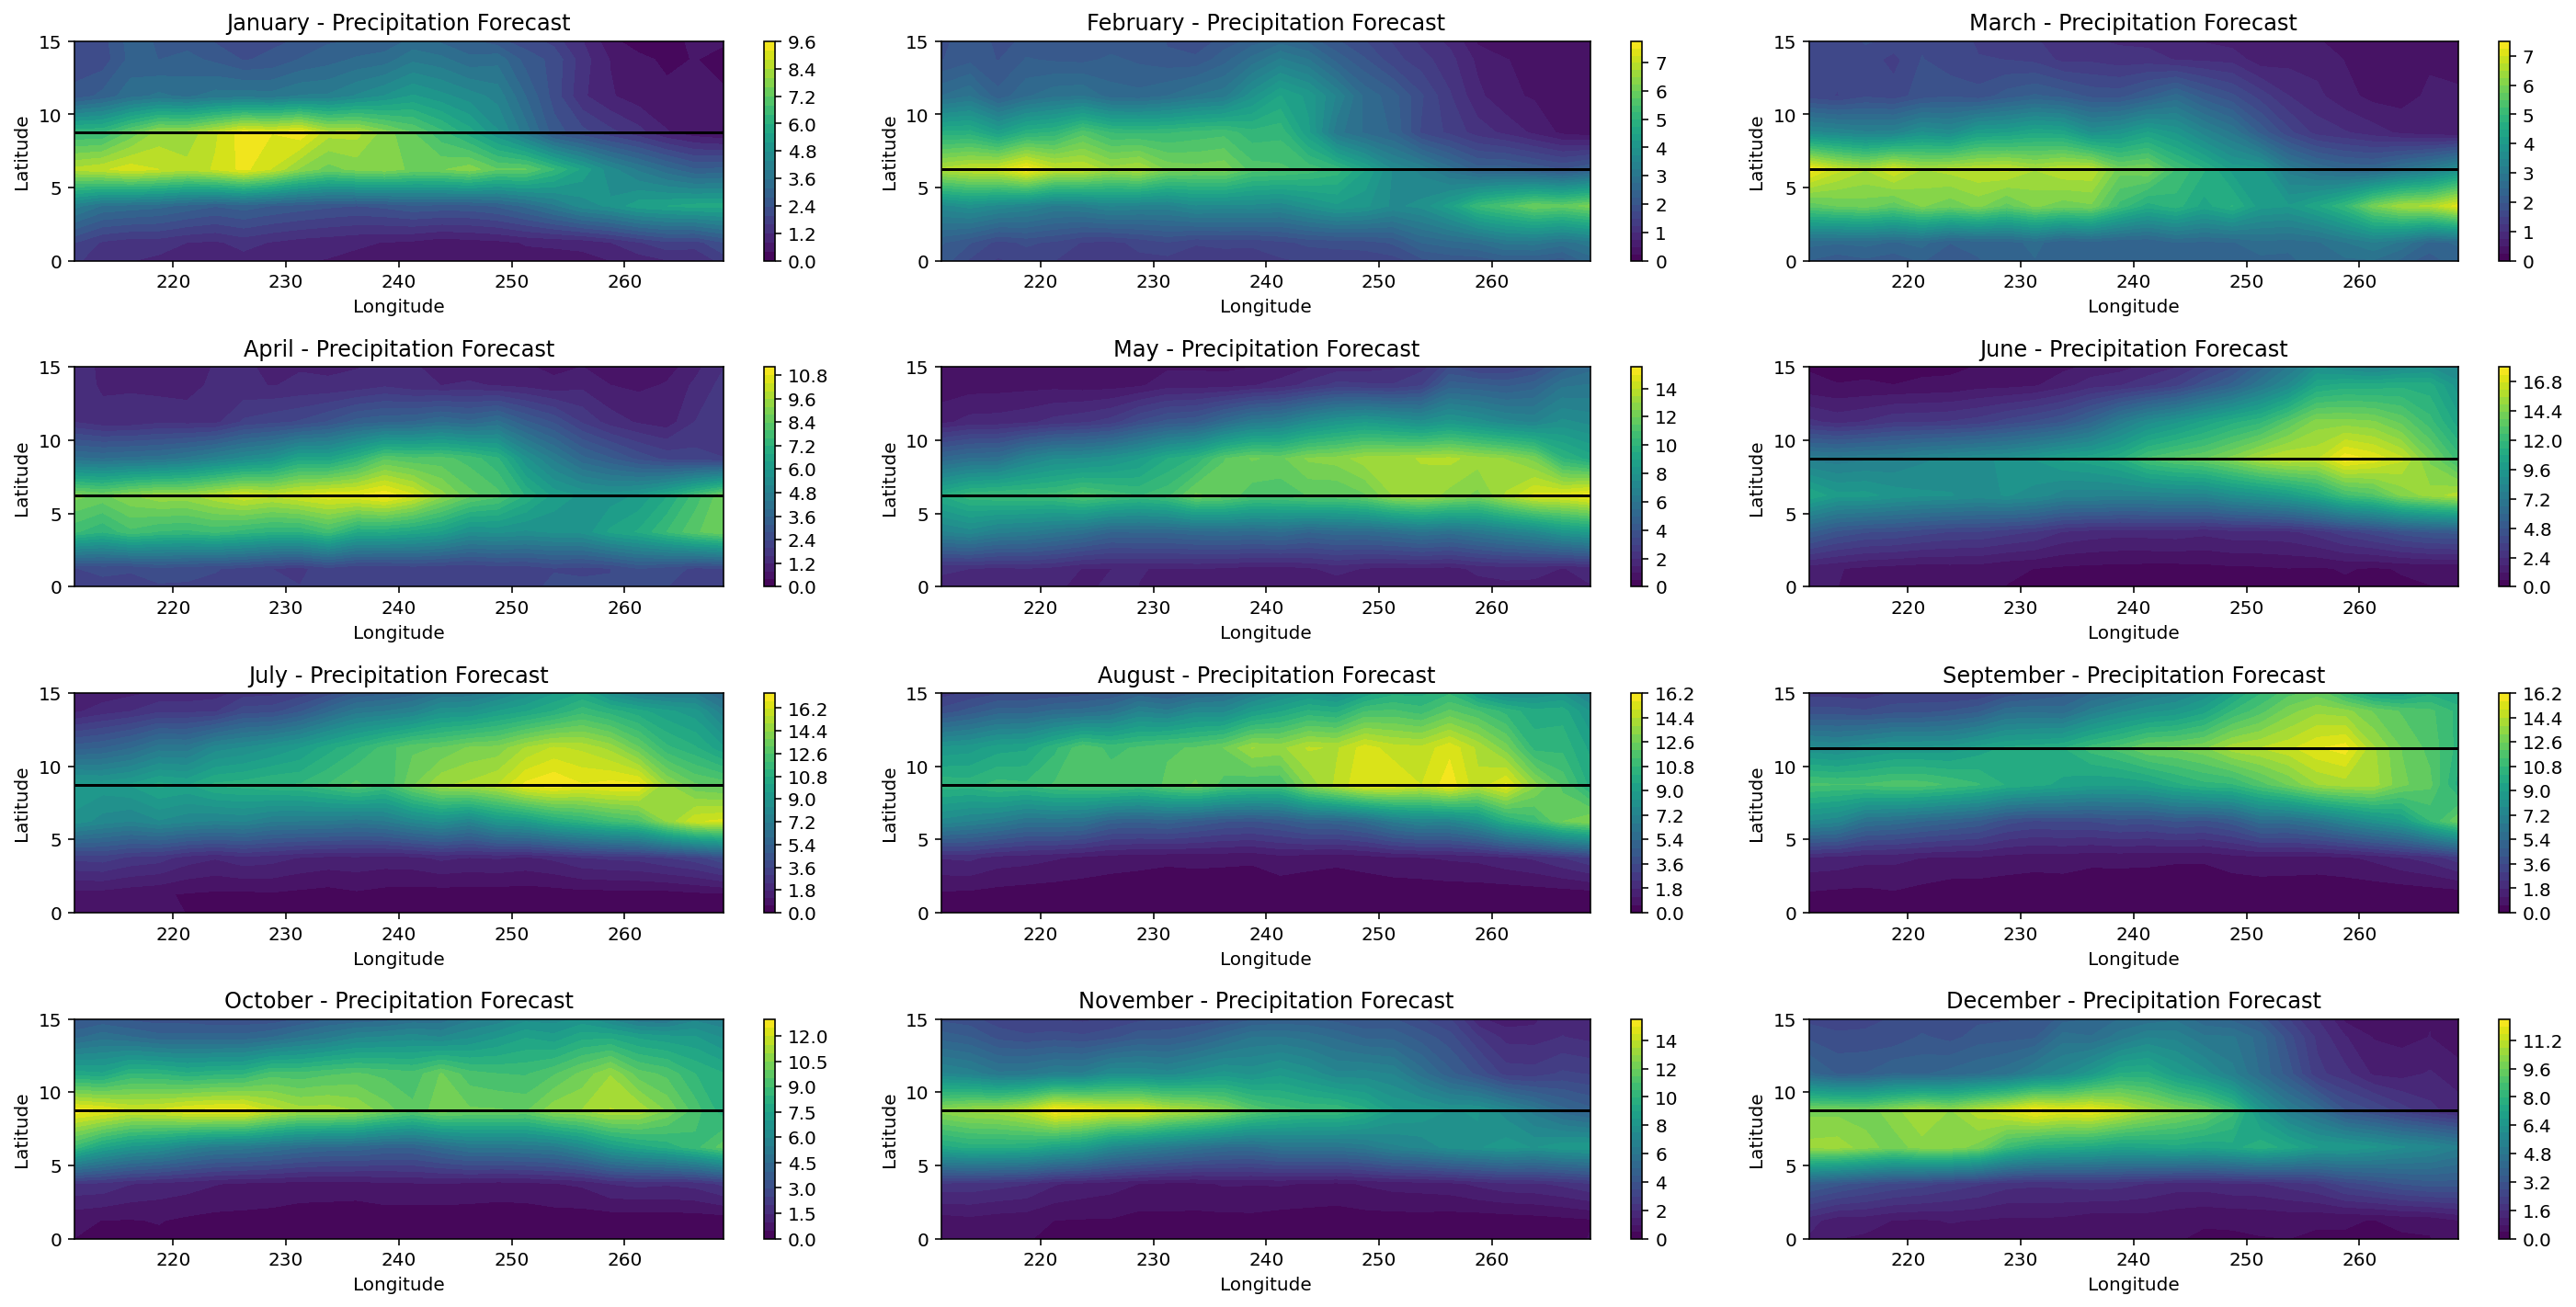

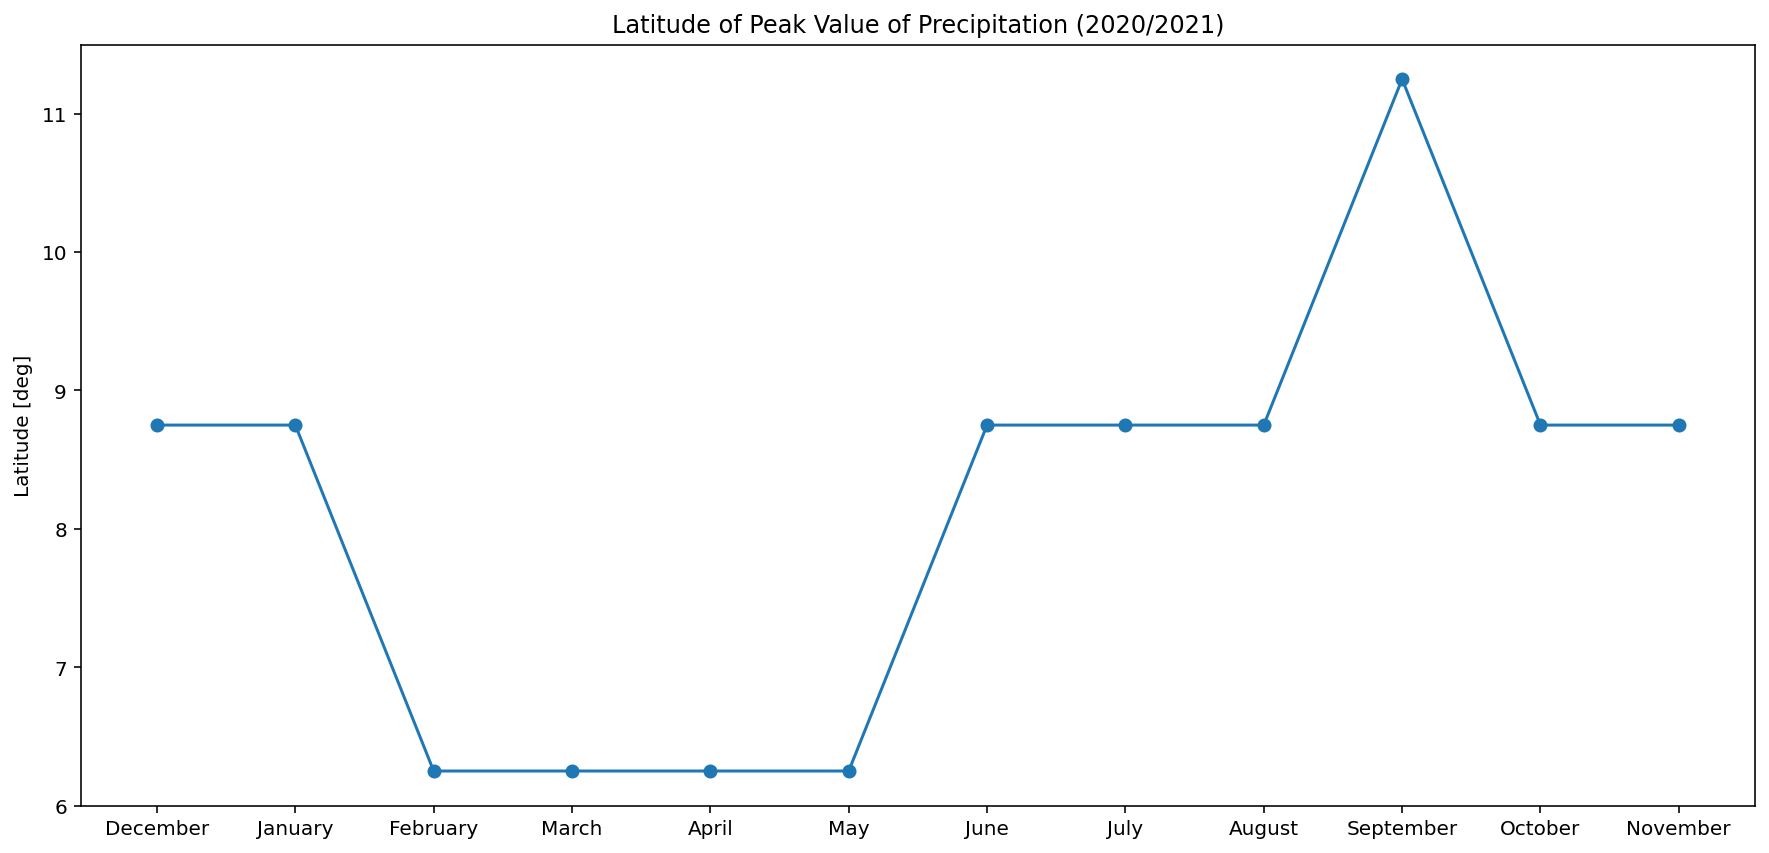

In [344]:
prcp_map_t = prcp_map.transpose("T", "X", "Y")
 
fig, ax = plt.subplots(4,3, figsize = (20,10))
ax = ax.flatten()

# Monthly values
prcp_map_nov = prcp_map_t[0::12]
prcp_map_dec = prcp_map_t[1::12]
prcp_map_jan = prcp_map_t[2::12]
prcp_map_feb = prcp_map_t[3::12]
prcp_map_mar = prcp_map_t[4::12]
prcp_map_apr = prcp_map_t[5::12]
prcp_map_may = prcp_map_t[6::12]
prcp_map_jun = prcp_map_t[7::12]
prcp_map_jul = prcp_map_t[8::12]
prcp_map_aug = prcp_map_t[9::12]
prcp_map_sep = prcp_map_t[10::12]
prcp_map_oct = prcp_map_t[11::12]

prcp_months = [prcp_map_jan, prcp_map_feb, prcp_map_mar, prcp_map_apr, prcp_map_may, prcp_map_jun, prcp_map_jul, prcp_map_aug, prcp_map_sep, prcp_map_oct, prcp_map_nov, prcp_map_dec]
n3_months = [n3_jan, n3_feb, n3_mar, n3_apr, n3_may, n3_jun, n3_jul, n3_aug, n3_sep, n3_oct, n3_nov, n3_dec]

peak = np.empty(12)

# Loop 

for k, p_map in enumerate(prcp_months):

    # Train our prediction on value from 2020
    x = n3_months[k].values
    xm = x.mean()
    # xa = x - xm
    x0 = n3_months[k][-1].values
    y = p_map.values
    N = len(y)

    Nx = len(x)
    X = np.empty((Nx,2))
    X[:,1] = x
    X[:,0] = 1
    
    index_0 = p_map.shape[0]
    index_1 = p_map.shape[1]
    index_2 = p_map.shape[2]

    beta = np.empty((2, index_1, index_2))
    yhat = np.empty((index_0, index_1, index_2))
    y0_hat = np.empty((index_0, index_1, index_2))

    for i in range(0, 24): 
        for j in range(0, 24): 
            beta[:,i,j] = inv(X.T@X)@X.T@y[:,i,j]
            yhat[:,i,j] = X@beta[:,i,j]
            y0_hat[:,i,j] = beta[1, i, j]*x0 + beta[0, i, j]

    yhat = yhat.mean(axis=0)
    y0_hat = y0_hat.mean(axis=0)

    X = p_map.X
    Y = p_map.Y
    Xi,Yi = np.meshgrid(X,Y)
    
    max_index = np.unravel_index(yhat.argmax(), yhat.shape)
    max_row = max_index[1]

    cs = ax[k].contourf(Xi, Yi, yhat.T, levels=30)
    ax[k].hlines(Y[max_row], X.min(), X.max())
    
    peak[k] = Y[max_row]
    
    # Get peak value  

    ax[k].set_title('%s - Precipitation Forecast'%months[k])
    ax[k].set_xlabel('Longitude')
    ax[k].set_ylabel('Latitude')
    
    ax[k].set_ylim(0, 15)

    fig.colorbar(cs, ax = ax[k])
    
plt.tight_layout()
plt.savefig("./Figures/Precip_forecast_2021.jpg")

fig, ax = plt.subplots(1,1,figsize = (15,7))
plt.plot(np.roll(months,1), np.roll(peak,1), '-o')
plt.title("Latitude of Peak Value of Precipitation (2020/2021)")
plt.ylabel("Latitude [deg]")
plt.savefig("./Figures/Precip_lat_peak_2021.jpg")

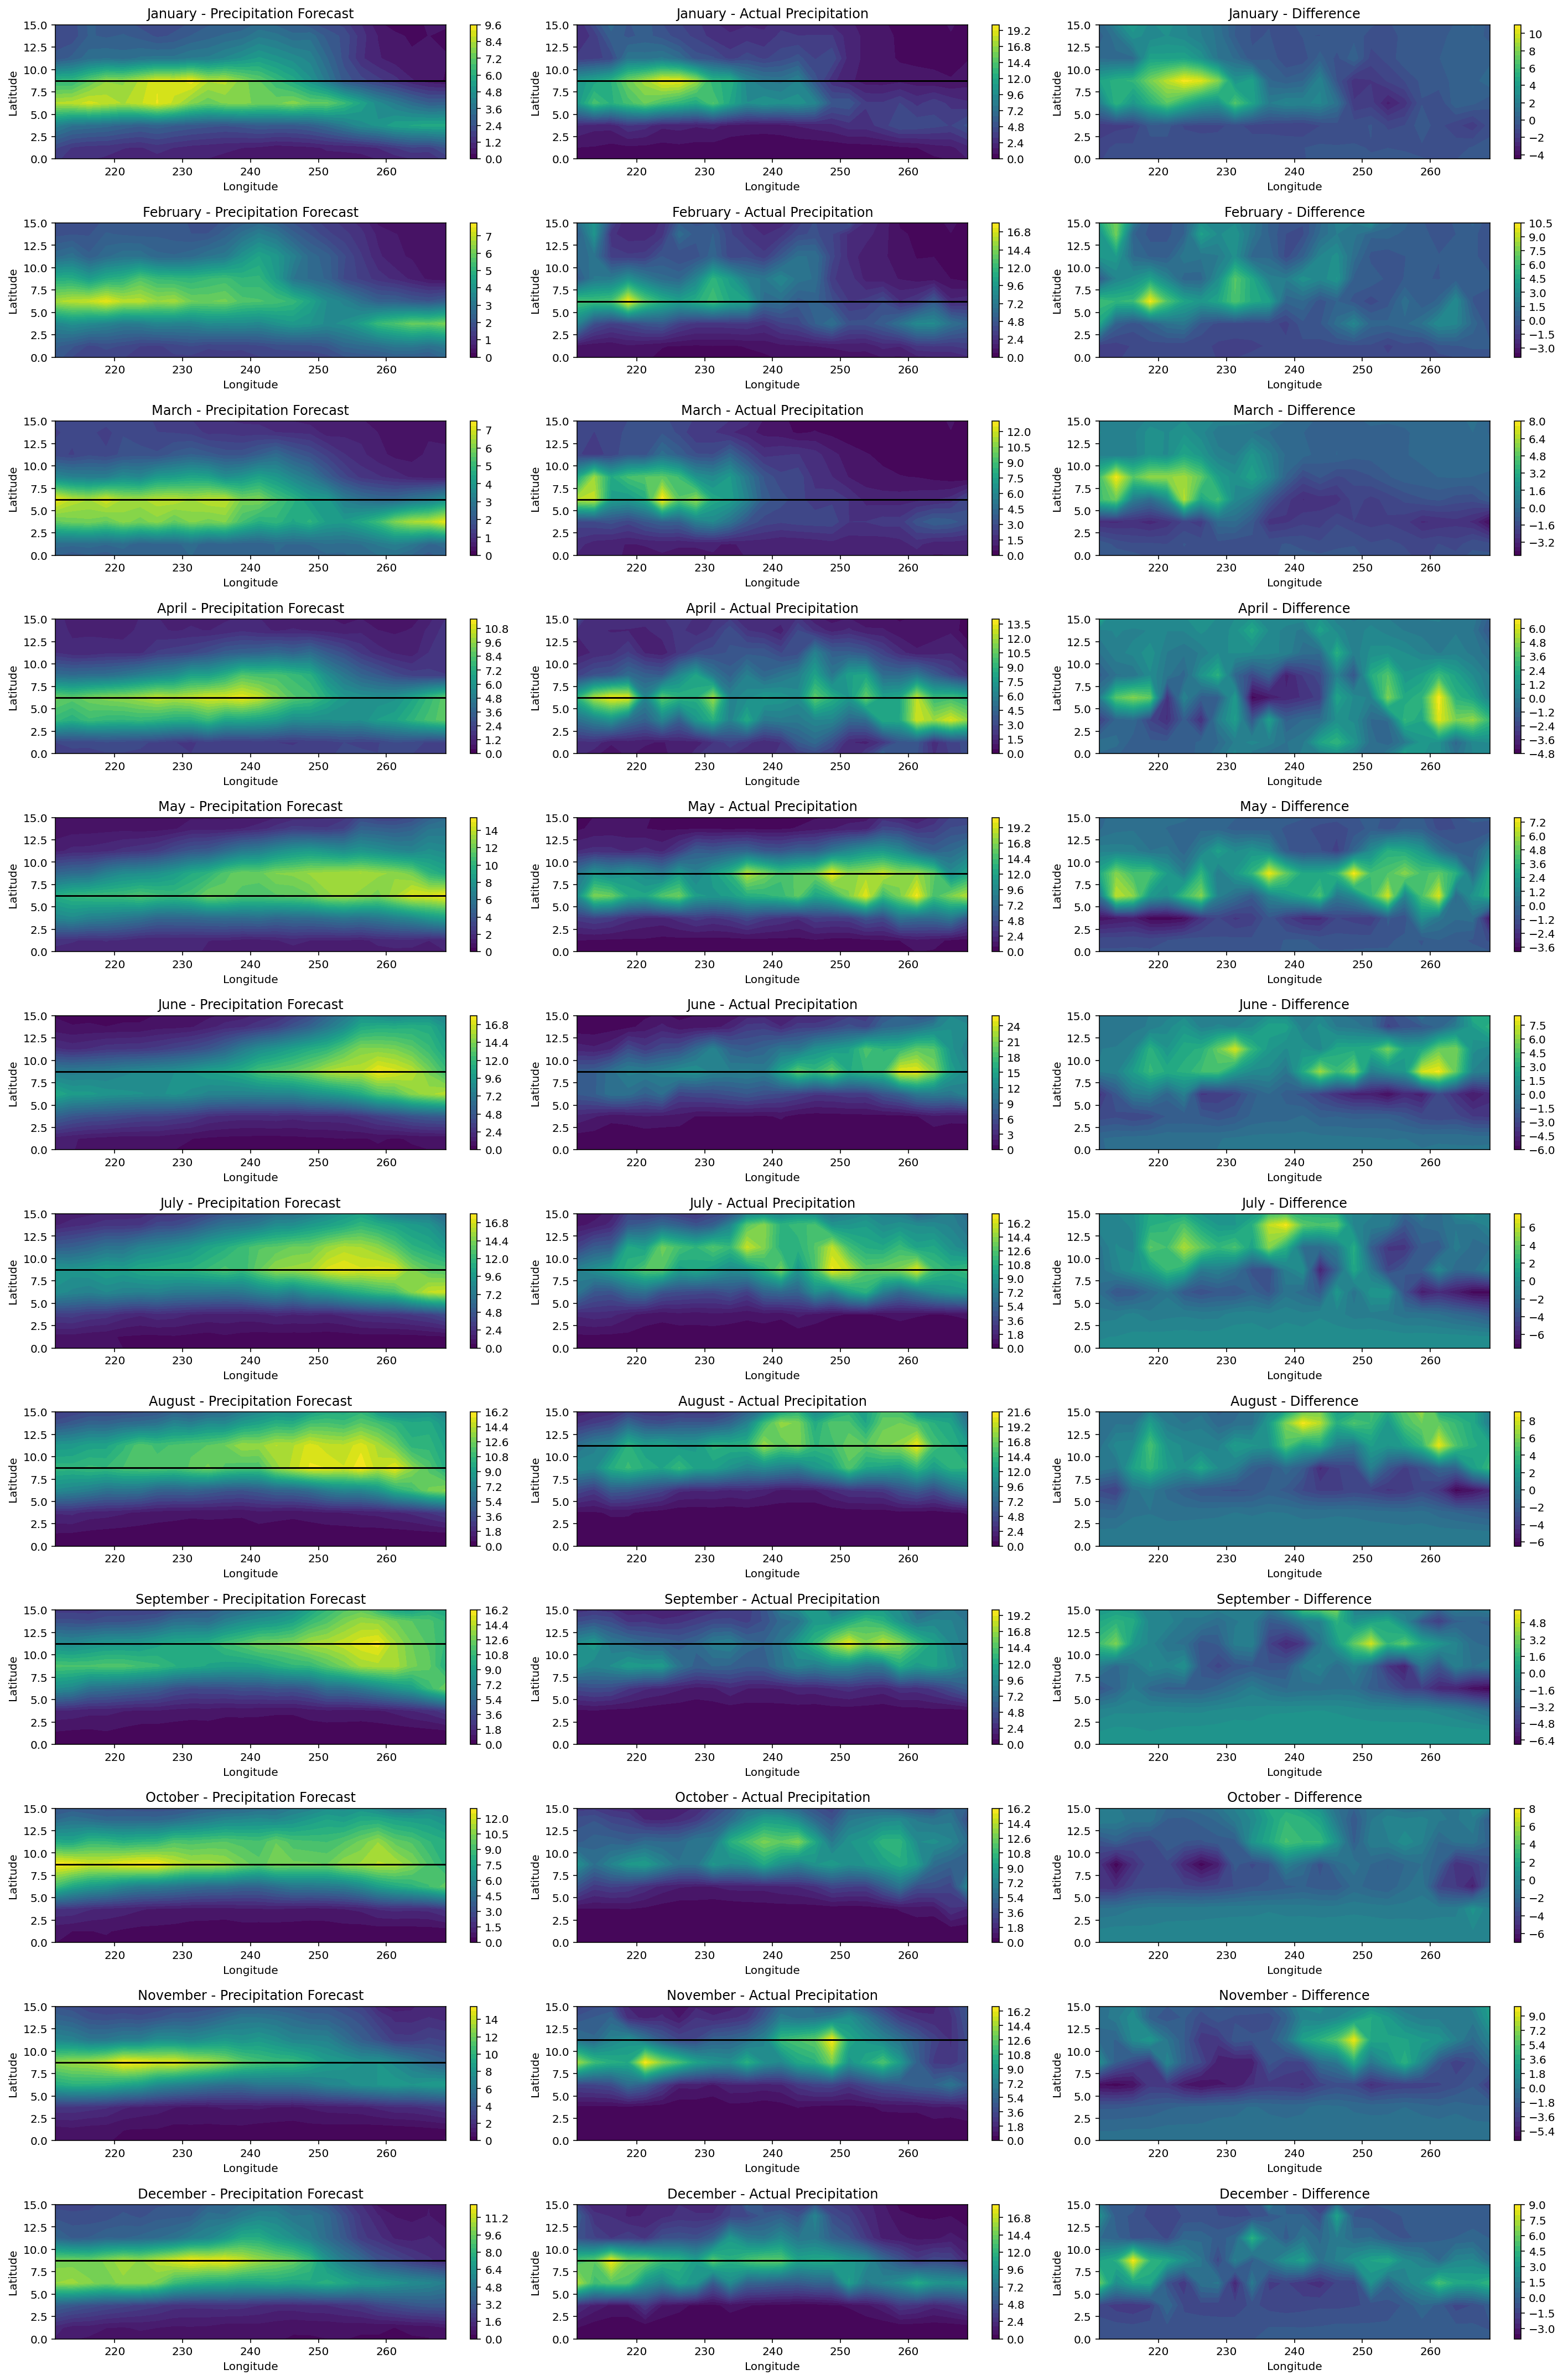

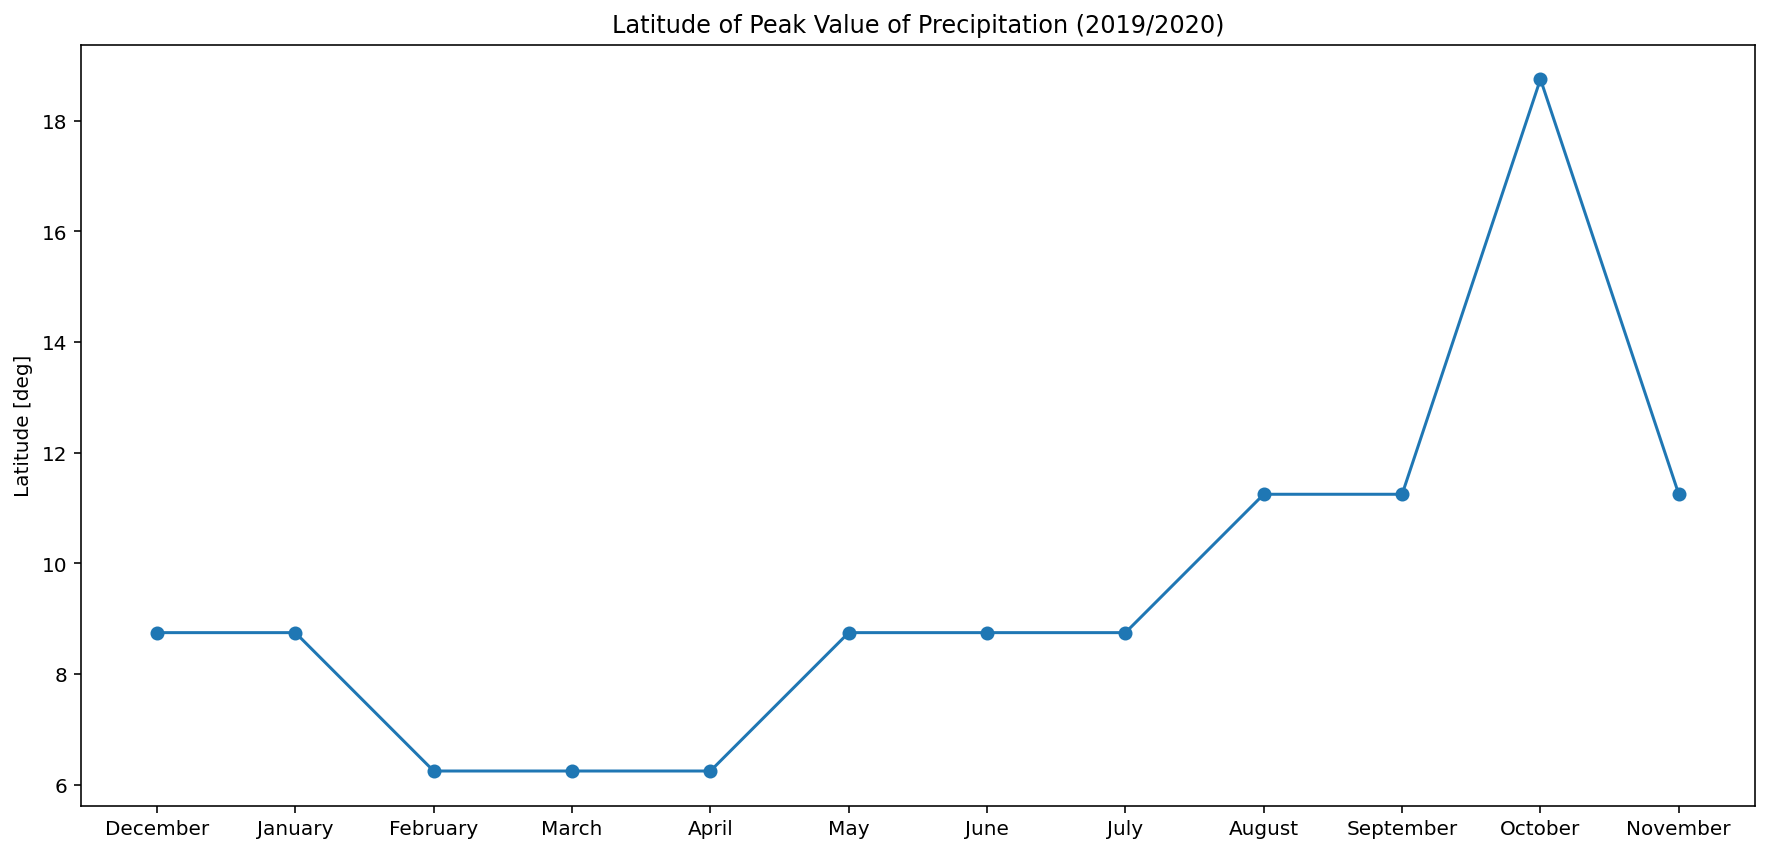

In [358]:
fig, ax = plt.subplots(12, 3, figsize = (20,30))
ax = ax.flatten()

for k, p_map in enumerate(prcp_months):

    # Train our prediction on value from 2020
    x = n3_months[k][:-1].values
    xm = x.mean()
    # xa = x - xm
    x0 = n3_months[k][-1].values
    y = p_map[:-1].values
    N = len(y)
    
#     print(k)

    Nx = len(x)
    X = np.empty((Nx,2))
    X[:,1] = x
    X[:,0] = 1
    
    index_0 = p_map.shape[0]
    index_1 = p_map.shape[1]
    index_2 = p_map.shape[2]

    beta = np.empty((2, index_1, index_2))
    yhat = np.empty((index_0-1, index_1, index_2))
    y0_hat = np.empty((index_0-1, index_1, index_2))

    for i in range(0, 24): 
        for j in range(0, 24): 
            beta[:,i,j] = inv(X.T@X)@X.T@y[:,i,j]
            yhat[:,i,j] = X@beta[:,i,j]
            y0_hat[:,i,j] = beta[1, i, j]*x0 + beta[0, i, j]

    yhat = yhat.mean(axis=0)
    y0_hat = y0_hat.mean(axis=0)

    X = p_map.X
    Y = p_map.Y
    Xi,Yi = np.meshgrid(X,Y)
    
    max_index = np.unravel_index(yhat.T.argmax(), yhat.T.shape)
    max_row = max_index[0]

    cs = ax[k*3].contourf(Xi, Yi, yhat.T, levels=30)
    ax[k*3].hlines(Y[max_row], X.min(), X.max())
    
    # Get peak value  

    ax[k*3].set_title('%s - Precipitation Forecast'%months[k])
    ax[k*3].set_xlabel('Longitude')
    ax[k*3].set_ylabel('Latitude')
    
    ax[k*3].set_ylim(0, 15)

    fig.colorbar(cs, ax = ax[k*3])
    
    cs = ax[k*3 + 1].contourf(Xi, Yi, p_map[-1].T.values, levels=30)

    ax[k*3 + 1].set_title('%s - Actual Precipitation'%months[k])
    ax[k*3 + 1].set_xlabel('Longitude')
    ax[k*3 + 1].set_ylabel('Latitude')
    ax[k*3 + 1].set_ylim(0, 15)
    
    max_index = np.unravel_index(p_map[-1].T.values.argmax(), p_map[-1].T.values.shape)
    max_row = max_index[0]
    
    peak[k] = Y[max_row]

    ax[k*3 + 1].hlines(Y[max_row], X.min(), X.max())    
    
    fig.colorbar(cs, ax = ax[k*3 + 1])

    cs = ax[k*3 + 2].contourf(Xi, Yi, p_map[-1].T.values - yhat.T, levels=30)

    ax[k*3 + 2].set_title('%s - Difference'%months[k])
    ax[k*3 + 2].set_xlabel('Longitude')
    ax[k*3 + 2].set_ylabel('Latitude')
    ax[k*3 + 2].set_ylim(0, 15)

    fig.colorbar(cs, ax = ax[k*3 + 2])
    
plt.tight_layout()
plt.savefig("./Figures/Precip_forecast_2020.jpg")

fig, ax = plt.subplots(1,1,figsize = (15,7))
plt.plot(np.roll(months,1), np.roll(peak,1), '-o')
plt.title("Latitude of Peak Value of Precipitation (2019/2020)")
plt.ylabel("Latitude [deg]")
plt.savefig("./Figures/Precip_lat_peak_2020.jpg")

## Precipitation Index

In [10]:
P_NEP = p.sel(lat = slice(10,2)).mean(['lat', 'lon'])
P_SEP  = p.sel(lat = slice(-2, -10)).mean(['lat', 'lon'])
P_EEE = p.sel(lat = slice(2, -2)).mean(['lat', 'lon'])

P_M = (1./3.) * (P_NEP + P_SEP + P_EEE)
I_A = (P_NEP - P_SEP) / P_M

# Anomaly 
ITCZ_anom = I_A.groupby('time.month') - I_A.groupby('time.month').mean()
ITCZa = ITCZ_anom.values

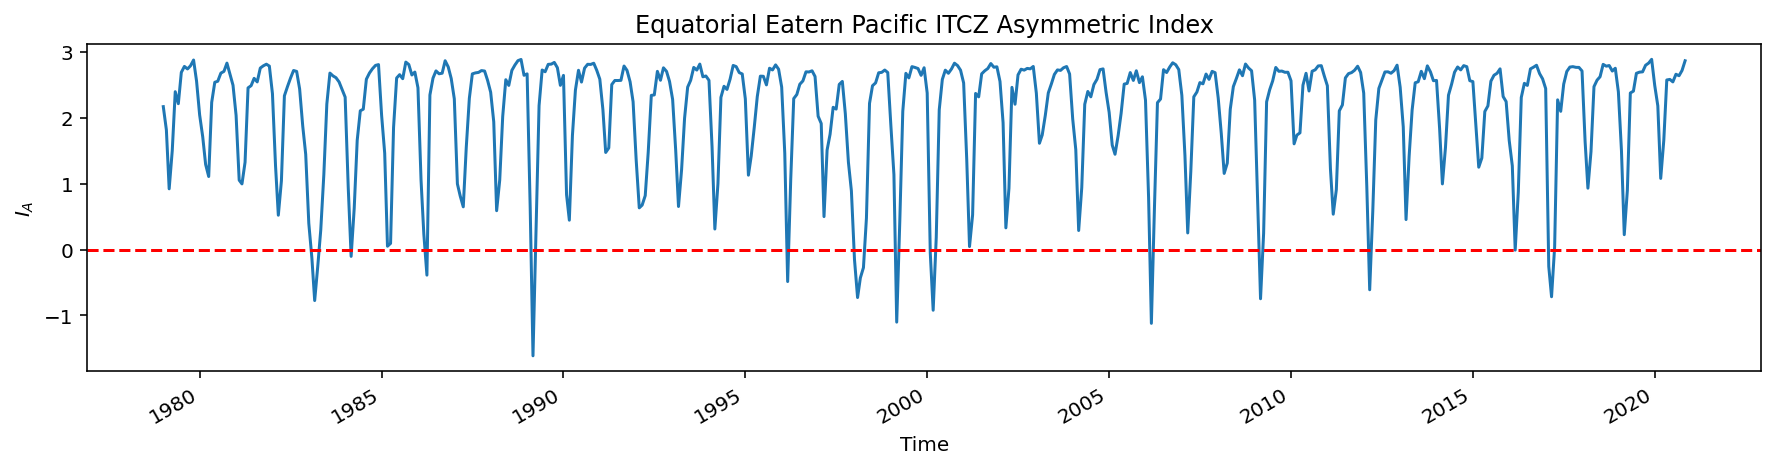

In [11]:
I_A.plot(x = 'time', figsize = (15,3))
plt.axhline(y=0, color='r', linestyle='--')

plt.title('Equatorial Eatern Pacific ITCZ Asymmetric Index')
plt.ylabel('$I_{A}$')
plt.savefig('EP_Precip_Index.jpg')

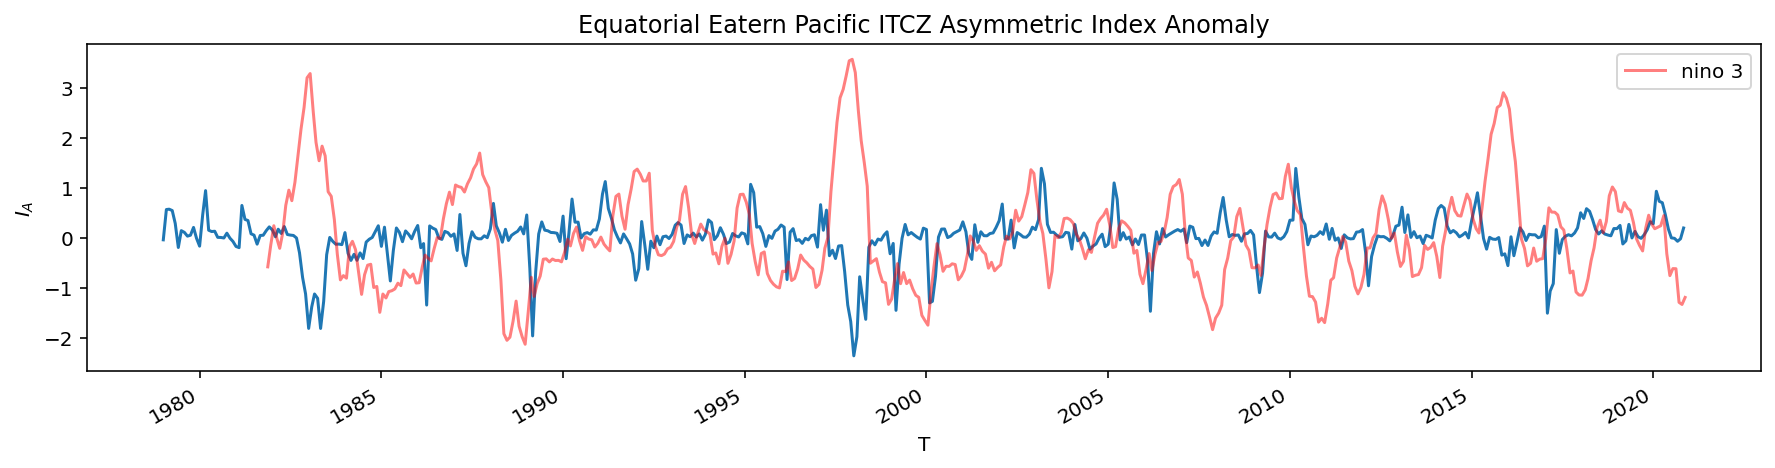

In [12]:
ITCZ_anom.plot(x = 'time', figsize = (15,3))
n3a.plot(color = 'r', alpha = 0.5, label = 'nino 3')

plt.title('Equatorial Eatern Pacific ITCZ Asymmetric Index Anomaly')
plt.legend() 
plt.ylabel('$I_{A}$')
plt.savefig('EP_Precip_Index_Anom.jpg')

### Correlation

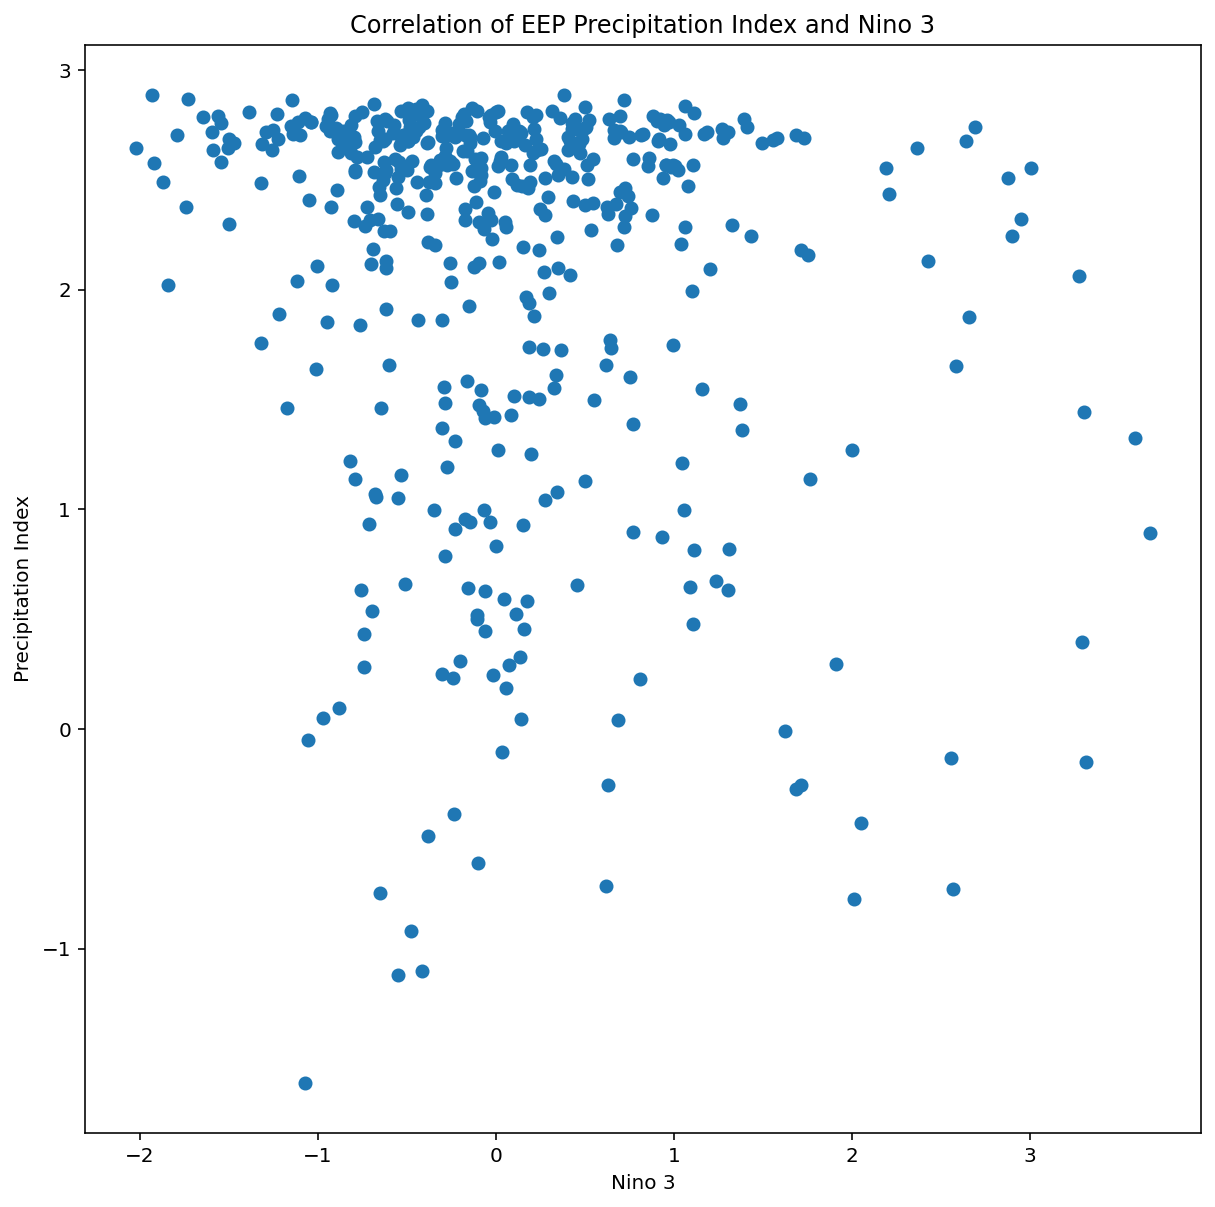

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

IA_n3 = I_A.sel(time = slice('1981-11-01', '2020-11-01'))

r_EEP_index = cor(n3, IA_n3.values)

axs.plot(n3,IA_n3.values,'o');
axs.set_xlabel('Nino 3');
axs.set_ylabel('Precipitation Index');
axs.set_title('Correlation of EEP Precipitation Index and Nino 3')

plt.savefig('Corr_index_N3.jpeg')

## Linear Regression

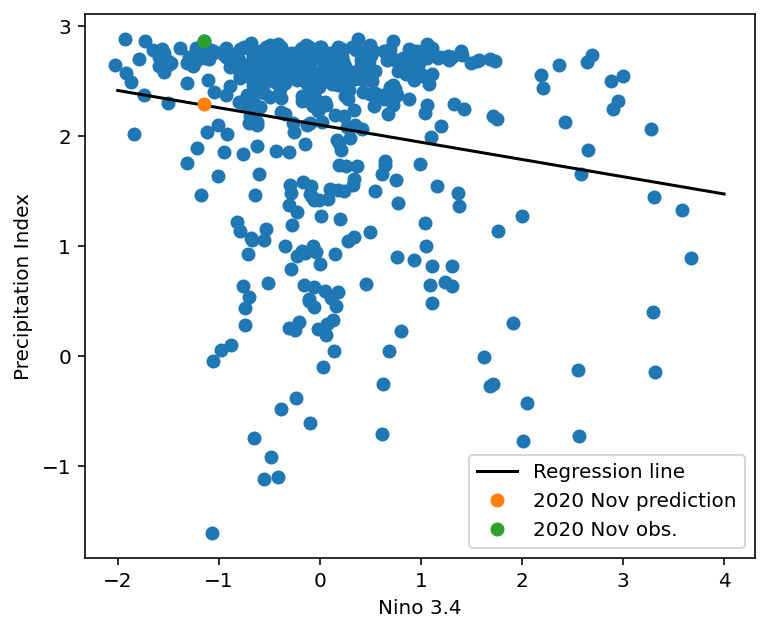

In [346]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(n3, IA_n3.values, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Precipitation Index');

from numpy.linalg import inv

y = IA_n3[:-1].values
yp = IA_n3[-1].values
x = n3[:-1]
xp = n3[-1]
xm = n3.mean()
Nx = len(x)
X = np.empty((Nx,2))
X[:,0] = x #<-------------------------------------------compare to below
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp - xm) + beta[1] 

x_line = np.linspace(-2, 4)

ax.plot(x_line, beta[0]*x_line + beta[1], 'k', label = 'Regression line');
ax.plot(xp, y_forecast_LR, 'o', label = '2020 Nov prediction')
ax.plot(xp, yp, 'o', label = '2020 Nov obs.')

ax.legend();

plt.savefig("./Figures/LR_index_N3.jpeg.jpg")

# SST Anomalies

Text(0.5, 1.0, 'Longitudinal SST Anomaly Average')

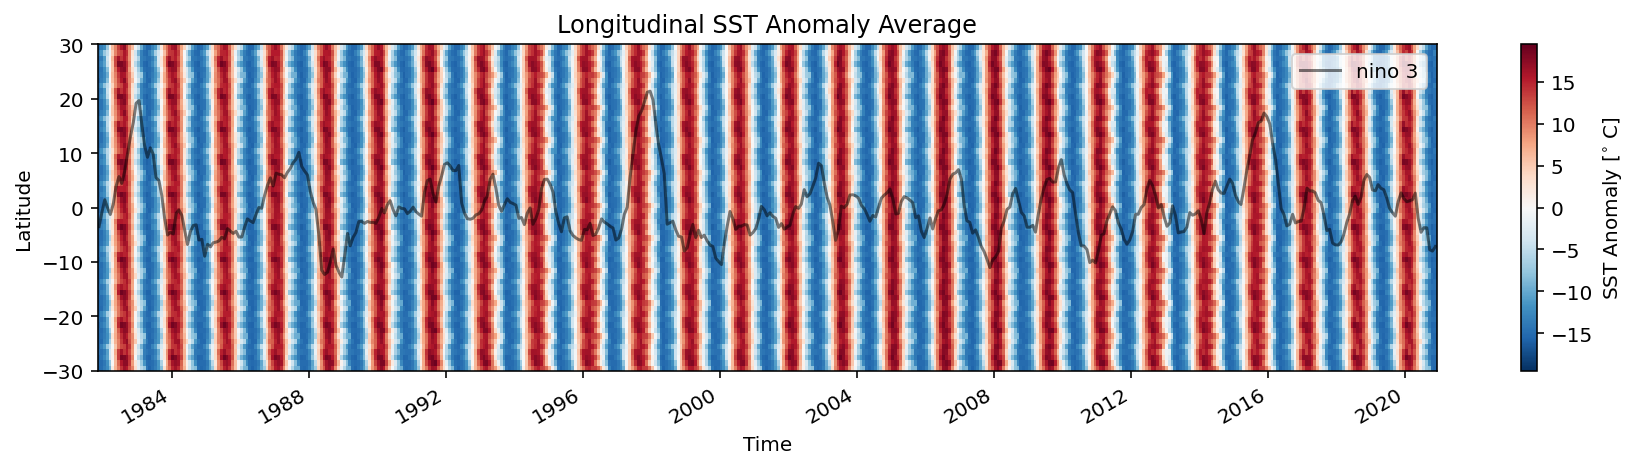

In [338]:
sst = sst_ds.sst
sst_ave = sst.mean('X')
sst_anom = sst_ave.groupby('T.month') - sst_ave.groupby('T.month').mean() 

im = sst_anom.plot(x = 'T', y = 'Y', figsize = (15,3), add_colorbar = False)
cb = plt.colorbar(im, orientation="vertical")
(6*n3a).plot(color = 'k', alpha = 0.5, label = 'nino 3')

cb.set_label(label='SST Anomaly [$^{\circ}$ C]')

plt.legend(); 
plt.ylabel('Latitude');
plt.xlabel('Time');
plt.title('Longitudinal SST Anomaly Average')
# plt.savefig('SSTa_ts.jpeg')

## Correlation

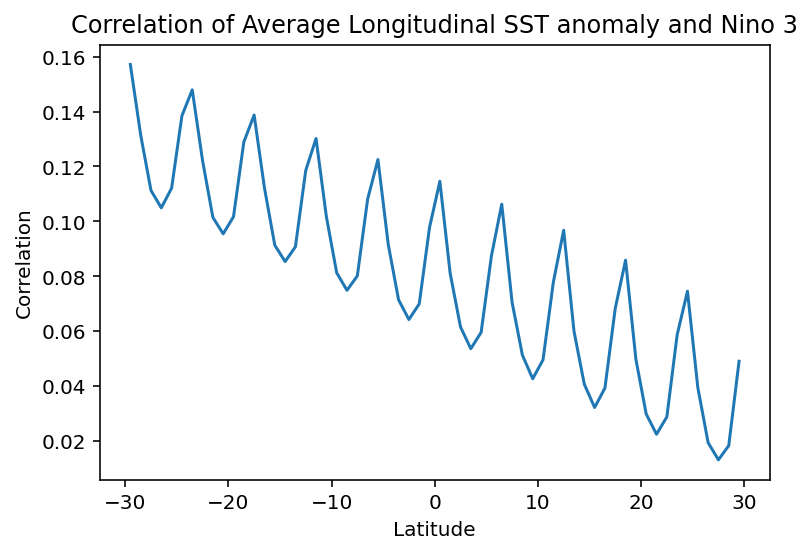

In [349]:
# Reindex like 
sst_anom_ri = sst_ave.T.reindex_like(n3, method='pad')

# Correlation
n3_ssta_corr = xr.corr(n3, sst_anom_ri, dim = 'T') 

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

n3_ssta_corr.plot(x = 'Y')
# ax.coastlines()
plt.title('Correlation of Average Longitudinal SST anomaly and Nino 3')
plt.xlabel('Latitude')
plt.ylabel('Correlation')
plt.savefig('Corr_SSTAnom_N3.jpeg')

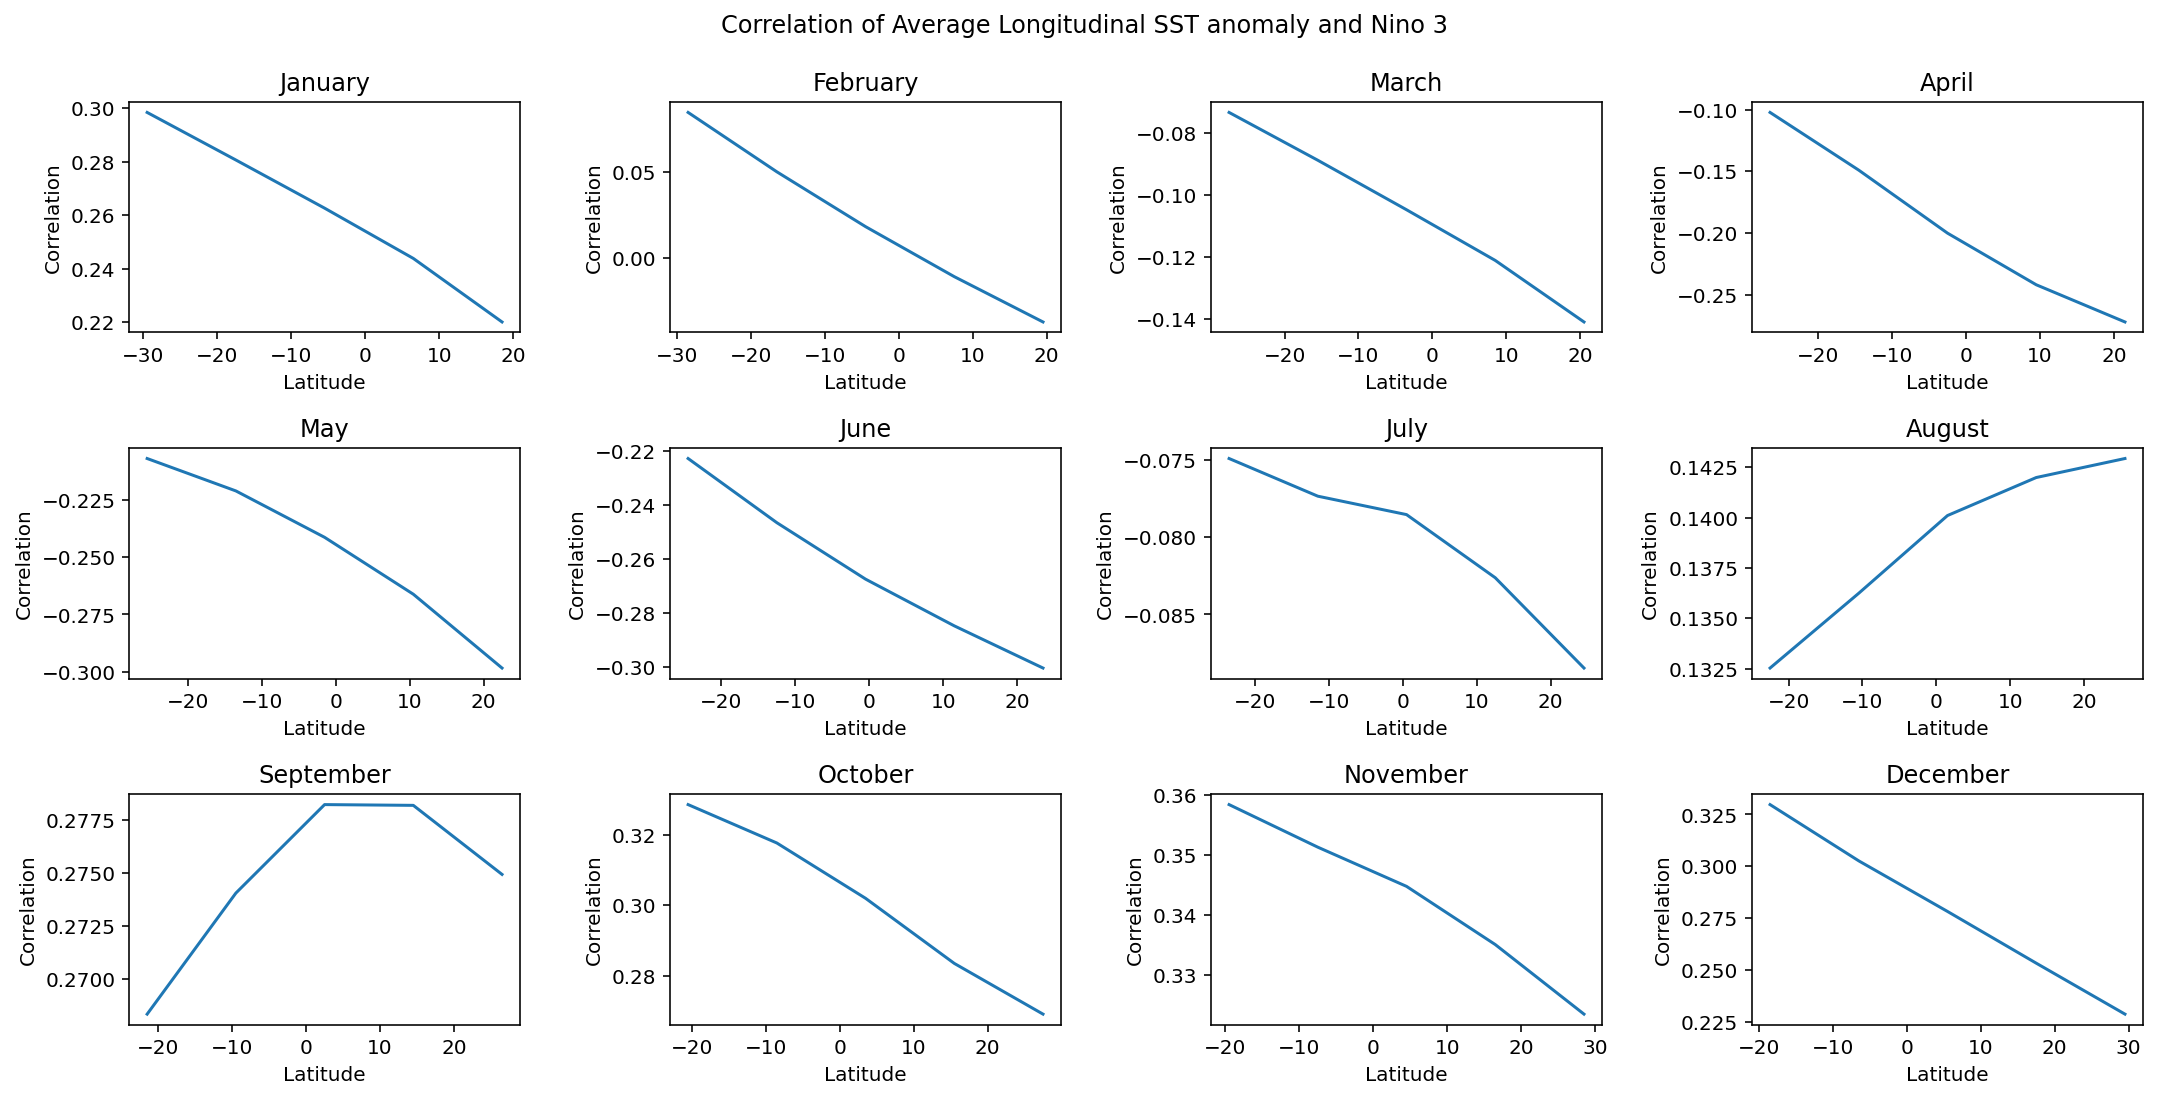

In [348]:
index = np.linspace(0, 11, 12)

fig, ax = plt.subplots(3,4, figsize = (15,8))
ax = ax.flatten()

for i in index: 
    i = int(i)

    n3_ssta_corr = xr.corr(n3[i::12], sst_anom_ri[i::12], dim = 'T')

    n3_ssta_corr.plot(x = 'Y', ax = ax[i])
    # ax.coastlines()
    ax[i].set_title('%s'%months[i])
    ax[i].set_xlabel('Latitude')
    ax[i].set_ylabel('Correlation')
#     plt.savefig('Corr_SSTAnom_N3.jpeg')

plt.suptitle("Correlation of Average Longitudinal SST anomaly and Nino 3")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./Figures/Corr_SST_montly.jpg')